In [165]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [166]:
Alco = pd.read_csv('Alcohol_Sales.csv', index_col='DATE', parse_dates=True)

In [167]:
Alco.index.freq='MS'

In [168]:
Alco.head()

,S4248SM144NCEN
DATE,
1992-01-01,3459
1992-02-01,3458
1992-03-01,4002
1992-04-01,4564
1992-05-01,4221


<Axes: xlabel='DATE'>

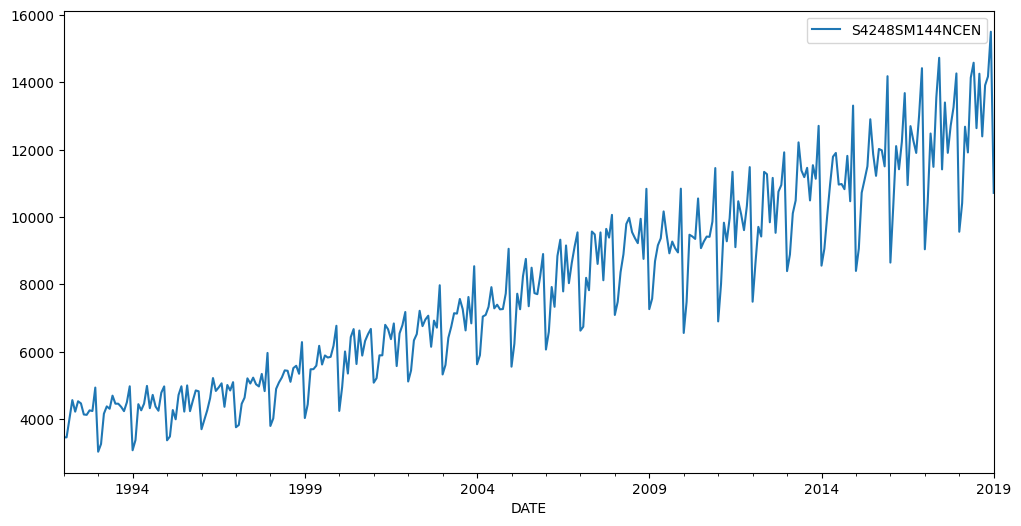

In [169]:
Alco.plot(figsize=(12,6))

In [170]:
from statsmodels.tsa.seasonal import seasonal_decompose

Далее выводятся графики по тренду, временные и верхний. Следует обращать внимание на Seasonal - желательно, чтобы четко видна была цикличность

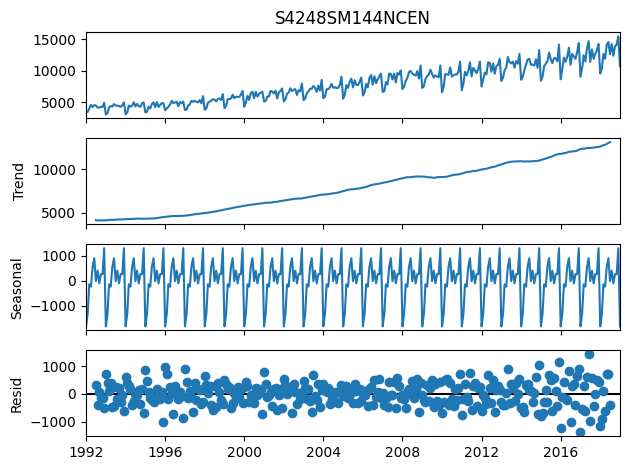

In [171]:
results = seasonal_decompose(Alco['S4248SM144NCEN'])
results.plot();

Проводим разделение на тренеровку и тестирование

In [172]:
len(Alco)

325

In [173]:
train = Alco.iloc[:300]
test = Alco.iloc[300:]

Нормализация данных (приводим в промежуток от[0;1])

In [174]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [175]:
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [176]:
from keras.preprocessing.sequence import TimeseriesGenerator

Генерируем временные ряды (по годовому - 12 = 12 месяцев)

In [180]:
n_input = 12
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [181]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [182]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 100)               40800     
                                                                 
 dense_4 (Dense)             (None, 1)                 101       
                                                                 
Total params: 40901 (159.77 KB)
Trainable params: 40901 (159.77 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [183]:
model.fit(generator,epochs=100)

Epoch 1/100
288/288 [==============================] - 2s 3ms/step - loss: 0.0145
Epoch 2/100
288/288 [==============================] - 1s 3ms/step - loss: 0.0081
Epoch 3/100
288/288 [==============================] - 1s 3ms/step - loss: 0.0082
Epoch 4/100
288/288 [==============================] - 1s 3ms/step - loss: 0.0085
Epoch 5/100
288/288 [==============================] - 1s 3ms/step - loss: 0.0068
Epoch 6/100
288/288 [==============================] - 1s 3ms/step - loss: 0.0062
Epoch 7/100
288/288 [==============================] - 1s 3ms/step - loss: 0.0045
Epoch 8/100
288/288 [==============================] - 1s 4ms/step - loss: 0.0037
Epoch 9/100
288/288 [==============================] - 1s 3ms/step - loss: 0.0030
Epoch 10/100
288/288 [==============================] - 1s 4ms/step - loss: 0.0028
Epoch 11/100
288/288 [==============================] - 1s 3ms/step - loss: 0.0022
Epoch 12/100
288/288 [==============================] - 1s 5ms/step - loss: 0.0021
Epoch 13/100


loss функция

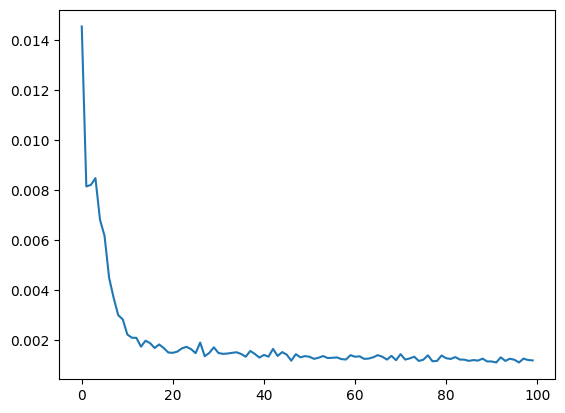

In [184]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

Сравним тренировку и тестирование

In [185]:
last_train_batch = scaled_train[-12:]
last_train_batch = last_train_batch.reshape((1, n_input, n_features))
model.predict(last_train_batch)

1/1 [==============================] - 0s 188ms/step


array([[0.50862545]], dtype=float32)

In [186]:
scaled_test[0]

array([0.52783143])

In [187]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):

    # get the prediction value for the first batch
    current_pred = model.predict(current_batch)[0]

    # append the prediction into the array
    test_predictions.append(current_pred)

    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 [==============================] - 0s 27ms/step


In [188]:
test.head()

,S4248SM144NCEN
DATE,
2017-01-01,9043
2017-02-01,10452
2017-03-01,12481
2017-04-01,11491
2017-05-01,13545


In [189]:
true_predictions = scaler.inverse_transform(test_predictions)
test['Predictions'] = true_predictions

C:\Users\vinan\AppData\Local\Temp\ipykernel_9904\425898741.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = true_predictions


Далее выводится полностью тестовая выборка (по сути предсказание)

<Axes: xlabel='DATE'>

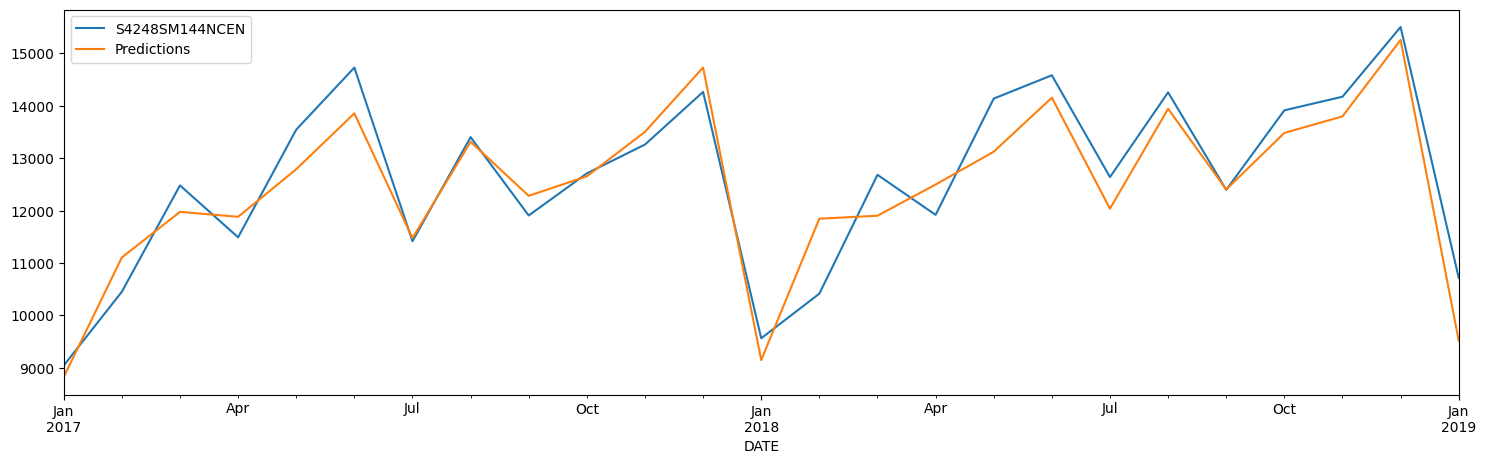

In [190]:
test.plot(figsize=(18,5))

Среднеквадратичная погрешность

In [191]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse=sqrt(mean_squared_error(test['S4248SM144NCEN'],test['Predictions']))
print(rmse)

610.3570012551885
